# Braket QPU Cost Estimator

Amazon Braket provides access to quantum computers, managed simulators that simulate quantum circuits, and managed notebook development environments. This notebook provides a simple function to estimate the cost of a simulation using a quantum computer and a set of cost estimate best practices to follow when submitting calculations.

There are two pricing components when using a quantum computer, or quantum processing unit (QPU), on Amazon Braket: a per-shot fee and a per-task fee.

A shot is a single execution of a quantum algorithm on a QPU. For example, a shot is a single pass through each stage of a complete quantum circuit on a gate-based QPU from IonQ or Rigetti. When you use a D-Wave quantum annealer, a shot is when you obtain a result sample of a quantum annealing problem. The per-shot pricing depends on the type of QPU used. The per-shot price is not affected by the number or type of gates used in a quantum circuit or the number of variables used in a quantum annealing problem.

A task is a sequence of repeated shots based on the same circuit design or annealing problem. You define how many shots you want included in a task when you submit the task to Amazon Braket. Per-task pricing is the same across all QPUs.

You will also be billed separately for use of each of these capabilities, as well as other AWS services that you use with Amazon Braket such as Amazon S3 for storing the results of quantum computations. The cost estimate function provided below does not account for the cost of these services. 

# Cost Estimate Function

In [1]:
from braket.aws import AwsDevice, AwsQuantumTask

In [2]:
def estimate_cost(device=None, tasks=1, shots_per_task = 1000):
    """
    Function to return the estimate cost of QPU simulation. 

    Input:
        device = AwsDevice("AWS_QPU_ARN")
        
            example: AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
            
        tasks = maximum number of tasks allowed in a variational calculation (user defined parameter)
        
        shots_per_task = number of shots per task (user defined parameter)
        
    
    Example output: 
        --------------------------------------------------------
        AWS Device:       'device_name'
        Number of tasks:  X
        Shots per task:   XXXX
        Price per task:   $X.X
        Price per shot:   $X.XX

        Cost estimate:    $X.XX 
        --------------------------------------------------------
        
    
    Note: 
        This function calculates the cost from the number of tasks and shots. 
        It does not include the cost associated with other AWS services (Braket notebooks, S3, etc.)
        
    """
    
    price_per_task = 0.3
            
    price_per_shot = device.properties.service.deviceCost.price
    price = tasks * price_per_task \
          + tasks * shots_per_task * price_per_shot  
    print('--------------------------------------------------------')
    print('AWS Device:       {}'.format(device.name))    
    print('Number of tasks:  {}'.format(tasks))
    print('Shots per task:   {}'.format(shots_per_task))
    print('Price per task:   $0.3')
    print('Price per shot:   ${}\n'.format(price_per_shot))
    print('Cost estimate:    ${}'.format(price)) 
    print('--------------------------------------------------------\n\n')
        

# Examples
In this section we provide two common scenarios where one may want to use the cost estimator function provided above.

In [3]:
# general imports
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit
from braket.devices import LocalSimulator

In [4]:
# Set the S3 bucket
my_bucket = # TODO:  Fill in the name of the bucket
my_prefix = "demo" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

## Example 1 - Single Task Simulations

In [5]:
# Define a Bell circuit
bell = Circuit().h(0).cnot(0, 1)
print(bell)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|


In [6]:
# Set the number of shots 
n_shots = 1000

### Best practice 1: 
Estimate the cost of your simulation BEFORE submitting to the QPU.

In [7]:
# Estimate the cost of this simulation on the Rigetti device
rigetti = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-8")
estimate_cost(device = rigetti, tasks = 1, shots_per_task = n_shots)

--------------------------------------------------------
AWS Device:       Aspen-8
Number of tasks:  1
Shots per task:   1000
Price per task:   $0.3
Price per shot:   $0.00035

Cost estimate:    $0.6499999999999999
--------------------------------------------------------




In [8]:
# Estimate the cost of this simulation on the IonQ device
ionq = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
estimate_cost(device = ionq, tasks = 1, shots_per_task = n_shots)

--------------------------------------------------------
AWS Device:       IonQ Device
Number of tasks:  1
Shots per task:   1000
Price per task:   $0.3
Price per shot:   $0.01

Cost estimate:    $10.3
--------------------------------------------------------




### Best practice 2: 
Perform a test calculation using one of the simulators to assess the quality of your algorithim under ideal conditions before using a QPU.

Counter({'11': 503, '00': 497})


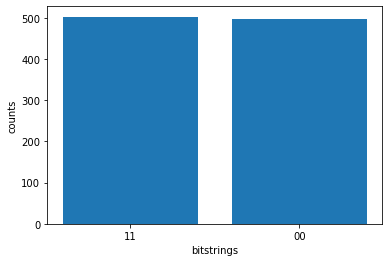

In [9]:
# LocalSimulator
device = LocalSimulator()
result = device.run(bell, shots = n_shots).result()
counts = result.measurement_counts

# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/tn1")
# result = device.run(bell, s3_folder, shots = n_shots).result()
# counts = result.measurement_counts

# print counts
print(counts)
# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

Finally, submit your task to the QPU.

In [ ]:
# QPUs (select one only if you are comfortable with the cost calculated above)
# device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
# device = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-8")
# result = device.run(bell, s3_folder, shots = n_shots).result()
# counts = result.measurement_counts

# print counts
print(counts)
# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

## Example 2 - Hybrid Algorithms
In this example we cover the best practices for implementing a hybrid algorithm (or any algorithm that require multiple iterations until a preset convergence criteria is met). For simplicity, this example will not optimize a circut parameter to minimize an objective function like is done in hybrid algorithms, e.g. the Variational Quantum Eigensolver. Instead we will define a convergence critera with little probablility of being met to highlight the importance of performing cost analysis prior to submitting calculations to the QPUs.

We will utilize the Bell circuit from Example 1, but this time execute the circuit in a loop. We will define "convergence" (i.e. the criteria that must be met before exiting the loop) to be a sample where the effects of noise (decoherence) and other imperfections are minimal. That is, when states '01' and '10' account for less than 1% of the samples (the number of times '01' and '10' are observed are less than or equal to 10).

### Best practice 1: 
Set a maximum number of iterations to ensure the algorithm stops if convergence is not met.

In [10]:
max_iter = 100

### Best practice 2: 
Estimate the cost of your simulation BEFORE submitting to the QPU. This will provide you with an estimate of the maximum cost should you algorithm fail to converge. Based on the results of the cost estimate, select the QPU and adjust the parameters until you are comfortable with the estimated maximum cost of your simulation. 

In [11]:
# Estimate the maximum cost of this simulation on the Rigetti device
estimate_cost(device=rigetti, tasks=max_iter, shots_per_task=n_shots)

--------------------------------------------------------
AWS Device:       Aspen-8
Number of tasks:  100
Shots per task:   1000
Price per task:   $0.3
Price per shot:   $0.00035

Cost estimate:    $65.0
--------------------------------------------------------




In [12]:
# Estimate the maximum cost of this simulation on the IonQ device
estimate_cost(device=ionq, tasks=max_iter, shots_per_task=n_shots)

--------------------------------------------------------
AWS Device:       IonQ Device
Number of tasks:  100
Shots per task:   1000
Price per task:   $0.3
Price per shot:   $0.01

Cost estimate:    $1030.0
--------------------------------------------------------




### Best practice 3:
Perform a test calculation using one of the simulators to assess the quality of your algorithim under ideal conditions before using a QPU.

In [13]:
# Simulators 
device = LocalSimulator()
# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/tn1")

# QPUs (select one only if you are comfortable with the cost calculated above)
# device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
# device = AwsDevice("arn:aws:braket:::device/qpu/rigetti/Aspen-8")

In [14]:
for i in range(max_iter):
    
    # Run circuit (execute a SINGLE task with 1000 shots)
    
    # Submit to the LocalSimulator
    result = device.run(bell, shots = n_shots).result()
    
    # Submit to a QPU, SV1, or TN1
    # (use the QPU only if you are comfortable with the cost calculated above)
    # result = device.run(bell, s3_folder, shots = n_shots).result()
    
    # get measurement shots
    counts = result.measurement_counts
    
    # Check convergence criteria
    if counts['01'] + counts['10'] <= 10:
        print('calculation "converged"')
        break
        

calculation "converged"
